In [1]:
import nibabel as nib
import numpy as np
from dipy.io.streamline import load_tractogram, save_tractogram
import robustReebConstruction as rc
import os
import pickle
import networkx as nx
import visualization as vis
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
 %%time
trkpathI = "/media/hdd2/shailja/Crash/sphere1brush6/sub-1142k_ses-4_DSI_mc.src.gz.odf8.f5rec.gqi.1.25.cc.trk.gz"    
p_streamlines =  nib.streamlines.load(trkpathI)
print("n = ",len(p_streamlines.streamlines))
count = 0
streamlines = p_streamlines.streamlines
#Step 2: Reeb Graph Construction
eps =2.5
alpha = 3
delta = 2

H, node_loc = rc.constructRobustReeb(streamlines, eps, alpha, delta)
G = H

# 3d spring layout
pos = node_loc
# Extract node and edge positions from the layout
node_xyz = np.array([pos[v] for v in sorted(G)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])
edge_labels = nx.get_edge_attributes(G, "weight")
weight_labels = list(edge_labels.values())

n =  129
CPU times: user 18.6 s, sys: 167 ms, total: 18.8 s
Wall time: 18.4 s


In [3]:
#we need to seperate the X,Y,Z coordinates for Plotly
x_nodes = [node_loc[i][0] for i in H.nodes()]# x-coordinates of nodes
y_nodes = [node_loc[i][1] for i in H.nodes()]# y-coordinates
z_nodes = [node_loc[i][2] for i in H.nodes()]# z-coordinates

In [4]:
#We also need a list of edges to include in the plot
edge_list = H.edges()

In [5]:
#we  need to create lists that contain the starting and ending coordinates of each edge.
x_edges=[]
y_edges=[]
z_edges=[]

#need to fill these with all of the coordiates
for edge in edge_list:
    #format: [beginning,ending,None]
    x_coords = [node_loc[edge[0]][0],node_loc[edge[1]][0],None]
    x_edges.append(x_coords)

    y_coords = [node_loc[edge[0]][1],node_loc[edge[1]][1],None]
    y_edges.append(y_coords)

    z_coords = [node_loc[edge[0]][2],node_loc[edge[1]][2],None]
    z_edges.append(z_coords)


In [6]:
edge_labels.values()
weight_labels = list(edge_labels.values())

In [7]:
traces = []
for i in range(len(x_edges)):
    trace_edges = go.Scatter3d(x=x_edges[i],
                               y=y_edges[i],
                               z=z_edges[i],
                               mode='lines',
                               line=dict(color='black', width=weight_labels[i]*10),)
    traces.append(trace_edges)


In [8]:
xdata = []
ydata = []
zdata = [] 
for i in range(len(streamlines)):
    
    for j in streamlines[i]:
        xdata.append(j[0])
        ydata.append(j[1])
        zdata.append(j[2])
trace_data = go.Scatter3d(x=xdata,
                        y=ydata,
                        z=zdata,
                        mode='markers',
                        marker=dict(symbol='circle',color='#eb7a30', size=1),
                        hoverinfo=None)

In [9]:
#create a trace for the nodes
trace_nodes = go.Scatter3d(x=x_nodes,
                         y=y_nodes,
                        z=z_nodes,
                        mode='markers',                
                        marker=dict(symbol='circle',
                                    color = 'red',
                                    size=10,
                                    line=dict(color='red', width=0.5)),
                        
                        hoverinfo='text')

In [10]:
#we need to set the axis for the plot 
axis = dict(showbackground=False,
            showline=False,
            zeroline=False,
            showgrid=False,
            showticklabels=False,
            title='')

In [11]:
#also need to create the layout for our plot
layout = go.Layout(title= r'$\text{Corpus Callosum (CC): } \epsilon = 2.5, \alpha = 3, \delta = 5$',
                width=650,
                height=625,
                showlegend=False,
                scene=dict(xaxis=dict(axis),
                        yaxis=dict(axis),
                        zaxis=dict(axis),
                        ),
                margin=dict(t=100),
                hovermode='closest')

In [12]:
#Include the traces we want to plot and create a figure
data = traces + [trace_nodes, trace_data]
fig = go.Figure(data=data, layout=layout)
fig.show()

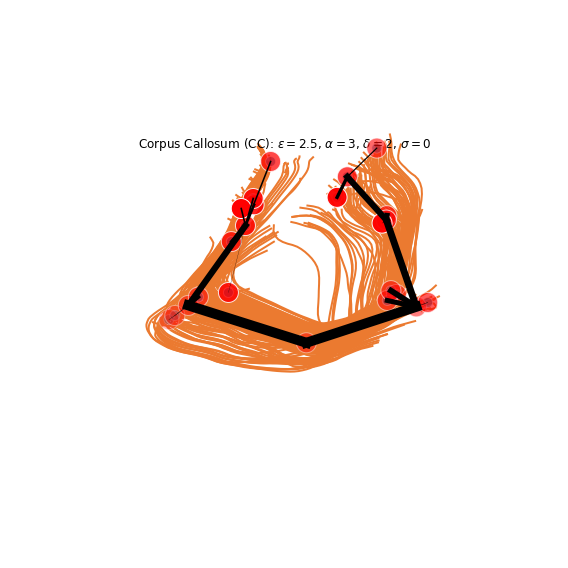

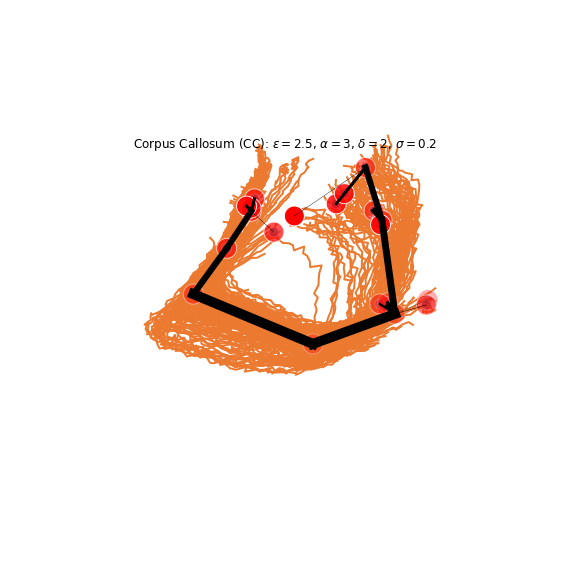

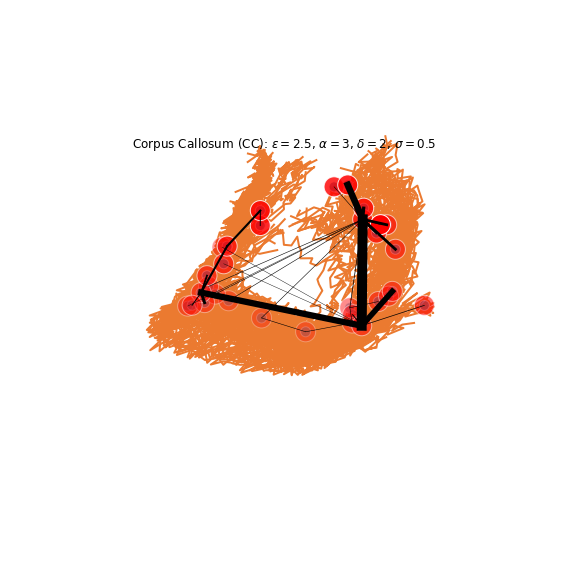

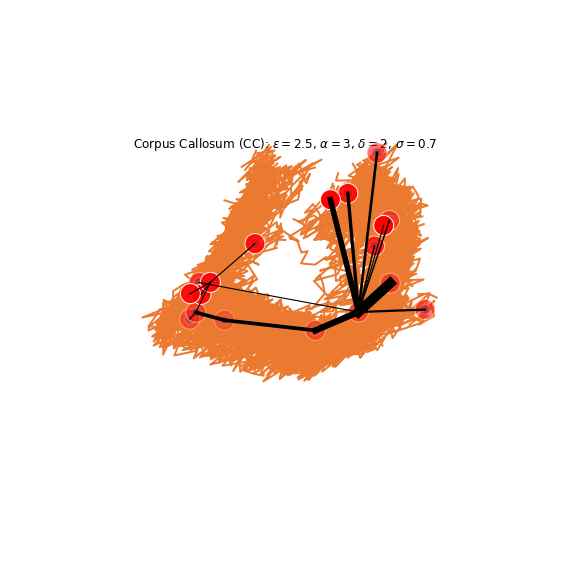

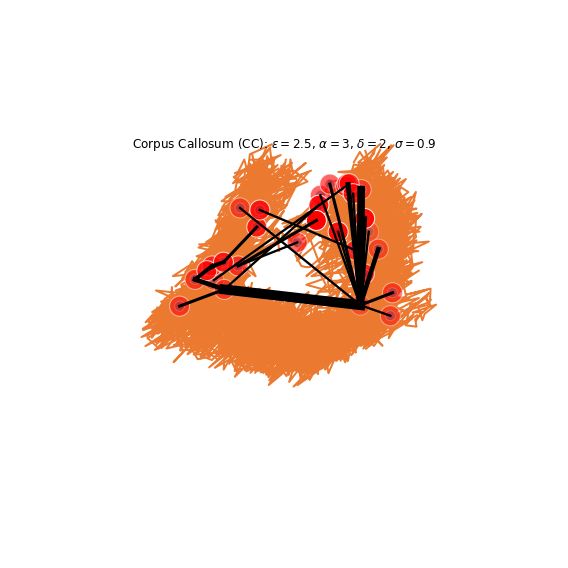

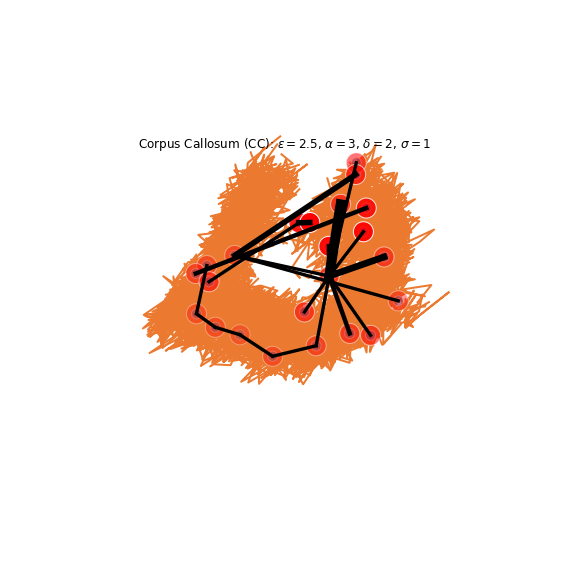

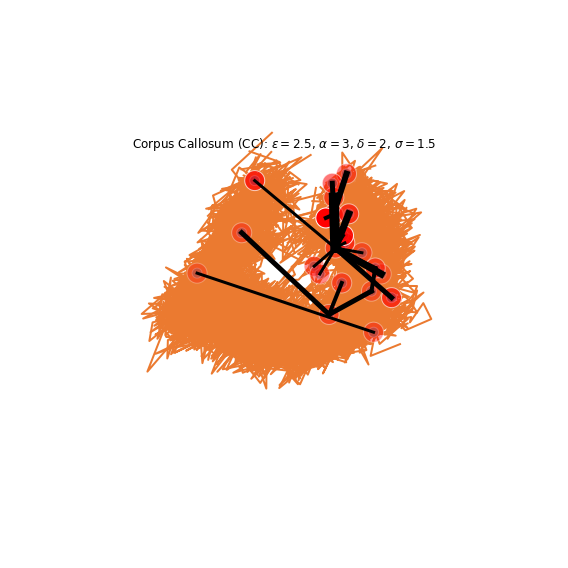

In [13]:
import numpy as np

# Define the standard deviation of the Gaussian noise
for sigma in [0,0.2,0.5,0.7,0.9,1,1.5]:

    # Iterate over each trajectory in the list
    for trajectory in streamlines:
        # Iterate over each point in the trajectory
        for i, point in enumerate(trajectory):
            # Generate a random 3D vector with Gaussian distribution and mean 0 and standard deviation sigma
            noise = np.random.normal(loc=0.0, scale=sigma, size=3)
            # Add the noise to the original point
            noisy_point = point + noise
            # Update the trajectory with the noisy point
            trajectory[i] = noisy_point
    H, node_loc = rc.constructRobustReeb(streamlines, eps, alpha, delta)
    G = H
    pos = node_loc
    node_xyz = np.array([pos[v] for v in sorted(G)])
    edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(*node_xyz.T, s=100, ec="w",label = None)
    for i in range(len(streamlines)):
        xdata = []
        ydata = []
        zdata = []
        for j in streamlines[i]:
            xdata.append(j[0])
            ydata.append(j[1])
            zdata.append(j[2])
        ax.plot3D(xdata,ydata,zdata,color= '#eb7a30', lw = 2);
    ax.scatter(*node_xyz.T, s=400, ec="w", color = 'r', zorder=100)
    edge_labels = nx.get_edge_attributes(G, "weight")
    weight_labels = list(edge_labels.values())
    count = 0
    for vizedge in edge_xyz:
        wt = weight_labels[count]/max(weight_labels)*10
        ax.plot(*vizedge.T, color='#000000',
                lw = wt,
                zorder = 50,
               label = str(weight_labels[count]))
        count+=1



    fig.tight_layout()
    plt.axis("off")

    plt.title(r'Corpus Callosum (CC): $\epsilon = %s$, $\alpha = %s$, $\delta = %s$, $\sigma = %s$' % (eps, alpha, delta, sigma),  y=0.8)
